# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

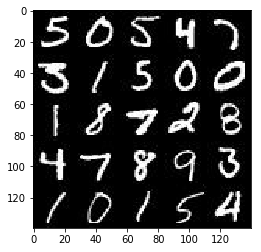

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

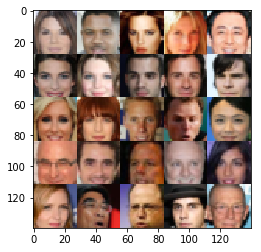

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(dtype=tf.float32, 
                                       shape = [None,image_width, image_height, image_channels], name='Input_image')
    z_data = tf.placeholder(dtype=tf.float32 , shape = [None,z_dim], name='z_input')
    LR = tf.placeholder(dtype = tf.float32, shape=[], name='learning_rate')

    return real_input_images, z_data, LR


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Hardcode a value for alpha
    alpha = 0.01 # For Leaky RELU
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # The Output of first convolution layer is 16 x 16 x 32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * batch2, batch2)
        # The Output of second convolution layer is 8 x 8 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * batch3, batch3)
        # The Output of third convolution layer is 4 x 4 x 256
        
        flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
#   We hardcode a value for alpha
    alpha = 0.2   # For Leaky RELU
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        # Reshape it to start the convolutions stack
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1 , x1)
        # The output of first Convolution connected layer is now 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2 , x2)
        # The output of second fully connected layer is now 7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2 , padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3 , x3)
        # The output of third fully connected layer is now 14 x 14 x 128
        
        # Output layer is 28 x 28 x out_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    real_input_images, z_data, LR = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_data,
                                              data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    figsize=(5,5)
    losses, samples = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, LR: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, LR: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_input_images: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, z_data, data_shape[3], data_image_mode)
        
        # Generate Discriminator vs Generator Loss Graph After completion of Epochs 
        # X axis value = steps / 10 since losses stored only after every 10 batches 
        fig, ax = pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator')
        pyplot.plot(losses.T[1], label='Generator')
        pyplot.title("Training Losses")
        pyplot.legend()
    
    return losses     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 2.0145... Generator Loss: 0.1668
Epoch 1/2... Batch 20... Discriminator Loss: 2.2214... Generator Loss: 0.1373
Epoch 1/2... Batch 30... Discriminator Loss: 1.3573... Generator Loss: 0.3951
Epoch 1/2... Batch 40... Discriminator Loss: 1.0706... Generator Loss: 0.5784
Epoch 1/2... Batch 50... Discriminator Loss: 1.4417... Generator Loss: 0.3417
Epoch 1/2... Batch 60... Discriminator Loss: 1.3551... Generator Loss: 0.4032
Epoch 1/2... Batch 70... Discriminator Loss: 1.3223... Generator Loss: 0.3972
Epoch 1/2... Batch 80... Discriminator Loss: 1.3615... Generator Loss: 0.3625
Epoch 1/2... Batch 90... Discriminator Loss: 1.3141... Generator Loss: 0.4246
Epoch 1/2... Batch 100... Discriminator Loss: 1.2024... Generator Loss: 0.4817


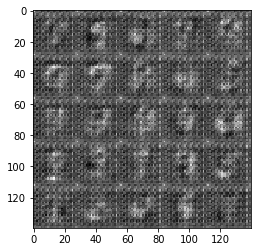

Epoch 1/2... Batch 110... Discriminator Loss: 1.2214... Generator Loss: 0.4492
Epoch 1/2... Batch 120... Discriminator Loss: 1.0695... Generator Loss: 0.5839
Epoch 1/2... Batch 130... Discriminator Loss: 1.1953... Generator Loss: 0.4779
Epoch 1/2... Batch 140... Discriminator Loss: 1.0522... Generator Loss: 0.5859
Epoch 1/2... Batch 150... Discriminator Loss: 0.9764... Generator Loss: 0.6562
Epoch 1/2... Batch 160... Discriminator Loss: 1.2194... Generator Loss: 0.4493
Epoch 1/2... Batch 170... Discriminator Loss: 0.8692... Generator Loss: 0.7688
Epoch 1/2... Batch 180... Discriminator Loss: 1.2215... Generator Loss: 0.4400
Epoch 1/2... Batch 190... Discriminator Loss: 1.0580... Generator Loss: 0.5438
Epoch 1/2... Batch 200... Discriminator Loss: 0.8760... Generator Loss: 0.7328


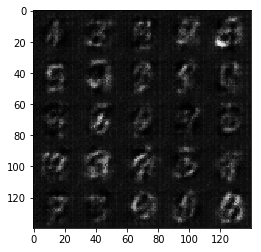

Epoch 1/2... Batch 210... Discriminator Loss: 1.3002... Generator Loss: 0.3805
Epoch 1/2... Batch 220... Discriminator Loss: 0.8350... Generator Loss: 0.8273
Epoch 1/2... Batch 230... Discriminator Loss: 0.9208... Generator Loss: 0.6772
Epoch 1/2... Batch 240... Discriminator Loss: 1.1062... Generator Loss: 0.4867
Epoch 1/2... Batch 250... Discriminator Loss: 0.8807... Generator Loss: 0.7348
Epoch 1/2... Batch 260... Discriminator Loss: 0.8605... Generator Loss: 0.7783
Epoch 1/2... Batch 270... Discriminator Loss: 0.7934... Generator Loss: 0.9187
Epoch 1/2... Batch 280... Discriminator Loss: 1.0620... Generator Loss: 0.5319
Epoch 1/2... Batch 290... Discriminator Loss: 0.9873... Generator Loss: 0.5844
Epoch 1/2... Batch 300... Discriminator Loss: 0.9443... Generator Loss: 0.6506


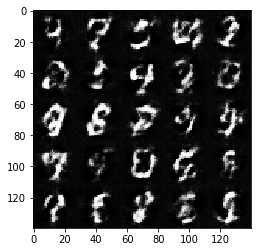

Epoch 1/2... Batch 310... Discriminator Loss: 0.8425... Generator Loss: 0.7675
Epoch 1/2... Batch 320... Discriminator Loss: 0.8146... Generator Loss: 0.8390
Epoch 1/2... Batch 330... Discriminator Loss: 1.2004... Generator Loss: 0.4550
Epoch 1/2... Batch 340... Discriminator Loss: 1.0529... Generator Loss: 0.5675
Epoch 1/2... Batch 350... Discriminator Loss: 0.7228... Generator Loss: 1.0011
Epoch 1/2... Batch 360... Discriminator Loss: 1.2556... Generator Loss: 0.4433
Epoch 1/2... Batch 370... Discriminator Loss: 0.8623... Generator Loss: 0.8014
Epoch 1/2... Batch 380... Discriminator Loss: 1.2343... Generator Loss: 0.4500
Epoch 1/2... Batch 390... Discriminator Loss: 1.0397... Generator Loss: 0.6232
Epoch 1/2... Batch 400... Discriminator Loss: 1.5622... Generator Loss: 0.2837


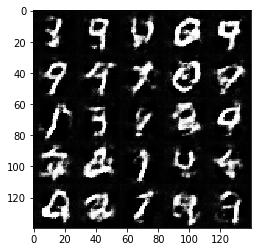

Epoch 1/2... Batch 410... Discriminator Loss: 0.9954... Generator Loss: 0.6306
Epoch 1/2... Batch 420... Discriminator Loss: 1.6312... Generator Loss: 0.2611
Epoch 1/2... Batch 430... Discriminator Loss: 1.0400... Generator Loss: 0.6246
Epoch 1/2... Batch 440... Discriminator Loss: 1.2123... Generator Loss: 0.4747
Epoch 1/2... Batch 450... Discriminator Loss: 1.1935... Generator Loss: 0.4984
Epoch 1/2... Batch 460... Discriminator Loss: 1.0687... Generator Loss: 1.7976
Epoch 2/2... Batch 470... Discriminator Loss: 1.0738... Generator Loss: 1.5657
Epoch 2/2... Batch 480... Discriminator Loss: 0.9669... Generator Loss: 1.6020
Epoch 2/2... Batch 490... Discriminator Loss: 1.1401... Generator Loss: 1.8893
Epoch 2/2... Batch 500... Discriminator Loss: 0.9346... Generator Loss: 0.9510


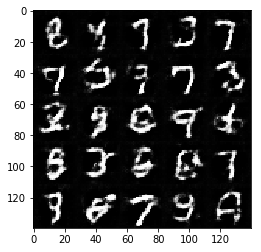

Epoch 2/2... Batch 510... Discriminator Loss: 1.4965... Generator Loss: 0.3098
Epoch 2/2... Batch 520... Discriminator Loss: 1.1127... Generator Loss: 0.5407
Epoch 2/2... Batch 530... Discriminator Loss: 1.2732... Generator Loss: 1.9716
Epoch 2/2... Batch 540... Discriminator Loss: 0.8781... Generator Loss: 1.2383
Epoch 2/2... Batch 550... Discriminator Loss: 0.9055... Generator Loss: 1.2432
Epoch 2/2... Batch 560... Discriminator Loss: 1.0838... Generator Loss: 1.8592
Epoch 2/2... Batch 570... Discriminator Loss: 0.9673... Generator Loss: 1.5076
Epoch 2/2... Batch 580... Discriminator Loss: 0.9487... Generator Loss: 1.3348
Epoch 2/2... Batch 590... Discriminator Loss: 1.0199... Generator Loss: 1.3381
Epoch 2/2... Batch 600... Discriminator Loss: 0.9408... Generator Loss: 0.7726


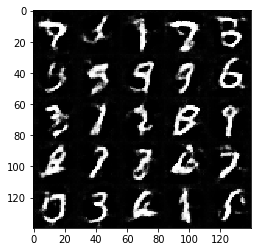

Epoch 2/2... Batch 610... Discriminator Loss: 1.2991... Generator Loss: 0.4295
Epoch 2/2... Batch 620... Discriminator Loss: 1.1262... Generator Loss: 0.5274
Epoch 2/2... Batch 630... Discriminator Loss: 1.0918... Generator Loss: 0.5776
Epoch 2/2... Batch 640... Discriminator Loss: 1.0661... Generator Loss: 1.2755
Epoch 2/2... Batch 650... Discriminator Loss: 0.9762... Generator Loss: 1.1195
Epoch 2/2... Batch 660... Discriminator Loss: 1.0795... Generator Loss: 1.3836
Epoch 2/2... Batch 670... Discriminator Loss: 1.0042... Generator Loss: 1.4363
Epoch 2/2... Batch 680... Discriminator Loss: 0.9369... Generator Loss: 1.0263
Epoch 2/2... Batch 690... Discriminator Loss: 1.0587... Generator Loss: 0.6304
Epoch 2/2... Batch 700... Discriminator Loss: 1.4460... Generator Loss: 0.3467


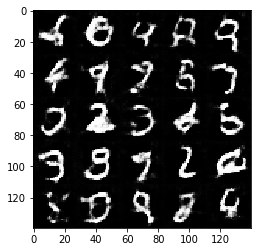

Epoch 2/2... Batch 710... Discriminator Loss: 0.9948... Generator Loss: 0.8332
Epoch 2/2... Batch 720... Discriminator Loss: 1.1888... Generator Loss: 1.6950
Epoch 2/2... Batch 730... Discriminator Loss: 0.9581... Generator Loss: 1.1765
Epoch 2/2... Batch 740... Discriminator Loss: 0.9652... Generator Loss: 0.8626
Epoch 2/2... Batch 750... Discriminator Loss: 1.5211... Generator Loss: 0.3012
Epoch 2/2... Batch 760... Discriminator Loss: 1.4673... Generator Loss: 0.3349
Epoch 2/2... Batch 770... Discriminator Loss: 1.0136... Generator Loss: 0.6470
Epoch 2/2... Batch 780... Discriminator Loss: 1.2538... Generator Loss: 0.4317
Epoch 2/2... Batch 790... Discriminator Loss: 1.0975... Generator Loss: 0.5866
Epoch 2/2... Batch 800... Discriminator Loss: 1.3226... Generator Loss: 0.4125


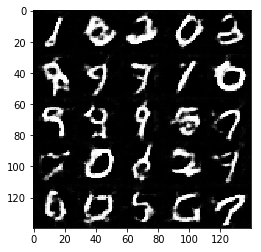

Epoch 2/2... Batch 810... Discriminator Loss: 0.9268... Generator Loss: 0.7973
Epoch 2/2... Batch 820... Discriminator Loss: 0.9864... Generator Loss: 1.5508
Epoch 2/2... Batch 830... Discriminator Loss: 0.9730... Generator Loss: 0.8083
Epoch 2/2... Batch 840... Discriminator Loss: 1.0020... Generator Loss: 1.5260
Epoch 2/2... Batch 850... Discriminator Loss: 0.8199... Generator Loss: 1.3841
Epoch 2/2... Batch 860... Discriminator Loss: 0.9814... Generator Loss: 1.4682
Epoch 2/2... Batch 870... Discriminator Loss: 0.8791... Generator Loss: 0.8171
Epoch 2/2... Batch 880... Discriminator Loss: 1.2620... Generator Loss: 0.4123
Epoch 2/2... Batch 890... Discriminator Loss: 1.5872... Generator Loss: 0.2922
Epoch 2/2... Batch 900... Discriminator Loss: 0.9779... Generator Loss: 0.7153


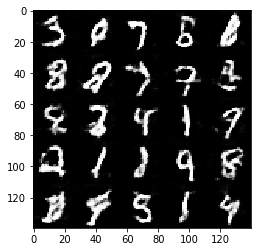

Epoch 2/2... Batch 910... Discriminator Loss: 1.1545... Generator Loss: 0.5349
Epoch 2/2... Batch 920... Discriminator Loss: 1.1749... Generator Loss: 0.5178
Epoch 2/2... Batch 930... Discriminator Loss: 0.9031... Generator Loss: 0.9466


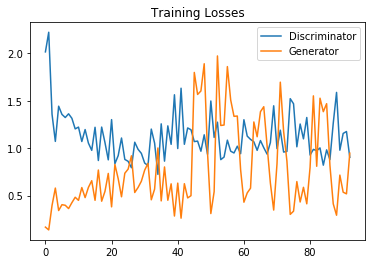

In [28]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.9737... Generator Loss: 0.2280
Epoch 1/1... Batch 20... Discriminator Loss: 1.2107... Generator Loss: 0.6091
Epoch 1/1... Batch 30... Discriminator Loss: 0.6872... Generator Loss: 1.4755
Epoch 1/1... Batch 40... Discriminator Loss: 2.0583... Generator Loss: 0.1652
Epoch 1/1... Batch 50... Discriminator Loss: 0.6192... Generator Loss: 2.0887
Epoch 1/1... Batch 60... Discriminator Loss: 1.0653... Generator Loss: 1.6620
Epoch 1/1... Batch 70... Discriminator Loss: 1.1564... Generator Loss: 1.2318
Epoch 1/1... Batch 80... Discriminator Loss: 1.0990... Generator Loss: 1.4634
Epoch 1/1... Batch 90... Discriminator Loss: 0.9347... Generator Loss: 1.2015
Epoch 1/1... Batch 100... Discriminator Loss: 1.1550... Generator Loss: 1.6027


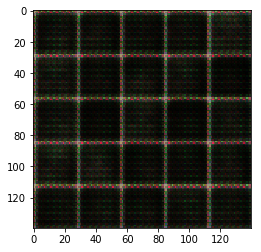

Epoch 1/1... Batch 110... Discriminator Loss: 1.3503... Generator Loss: 1.9163
Epoch 1/1... Batch 120... Discriminator Loss: 1.2874... Generator Loss: 1.0691
Epoch 1/1... Batch 130... Discriminator Loss: 1.2264... Generator Loss: 0.8280
Epoch 1/1... Batch 140... Discriminator Loss: 1.2132... Generator Loss: 0.5868
Epoch 1/1... Batch 150... Discriminator Loss: 0.9834... Generator Loss: 0.8088
Epoch 1/1... Batch 160... Discriminator Loss: 1.4164... Generator Loss: 0.4127
Epoch 1/1... Batch 170... Discriminator Loss: 1.3730... Generator Loss: 0.4246
Epoch 1/1... Batch 180... Discriminator Loss: 1.4256... Generator Loss: 0.4219
Epoch 1/1... Batch 190... Discriminator Loss: 1.3596... Generator Loss: 0.4794
Epoch 1/1... Batch 200... Discriminator Loss: 1.3536... Generator Loss: 0.4867


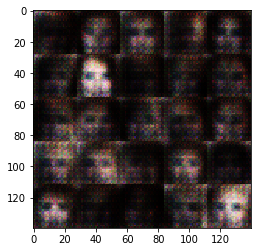

Epoch 1/1... Batch 210... Discriminator Loss: 0.9515... Generator Loss: 0.9345
Epoch 1/1... Batch 220... Discriminator Loss: 1.2927... Generator Loss: 0.6303
Epoch 1/1... Batch 230... Discriminator Loss: 1.5292... Generator Loss: 0.3372
Epoch 1/1... Batch 240... Discriminator Loss: 1.2798... Generator Loss: 0.4630
Epoch 1/1... Batch 250... Discriminator Loss: 1.0986... Generator Loss: 0.7601
Epoch 1/1... Batch 260... Discriminator Loss: 0.9026... Generator Loss: 1.0888
Epoch 1/1... Batch 270... Discriminator Loss: 1.2068... Generator Loss: 1.6157
Epoch 1/1... Batch 280... Discriminator Loss: 1.0140... Generator Loss: 0.8132
Epoch 1/1... Batch 290... Discriminator Loss: 1.2065... Generator Loss: 0.5791
Epoch 1/1... Batch 300... Discriminator Loss: 1.3593... Generator Loss: 0.4466


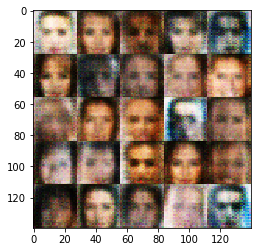

Epoch 1/1... Batch 310... Discriminator Loss: 1.3612... Generator Loss: 0.4568
Epoch 1/1... Batch 320... Discriminator Loss: 1.3629... Generator Loss: 1.6587
Epoch 1/1... Batch 330... Discriminator Loss: 1.2267... Generator Loss: 0.6217
Epoch 1/1... Batch 340... Discriminator Loss: 1.3203... Generator Loss: 0.5535
Epoch 1/1... Batch 350... Discriminator Loss: 1.2875... Generator Loss: 0.4809
Epoch 1/1... Batch 360... Discriminator Loss: 1.4850... Generator Loss: 0.3756
Epoch 1/1... Batch 370... Discriminator Loss: 1.4074... Generator Loss: 0.4644
Epoch 1/1... Batch 380... Discriminator Loss: 1.4853... Generator Loss: 0.3961
Epoch 1/1... Batch 390... Discriminator Loss: 1.4339... Generator Loss: 0.4077
Epoch 1/1... Batch 400... Discriminator Loss: 1.3865... Generator Loss: 0.5092


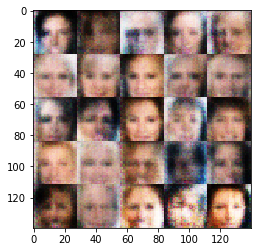

Epoch 1/1... Batch 410... Discriminator Loss: 1.3390... Generator Loss: 1.7194
Epoch 1/1... Batch 420... Discriminator Loss: 1.2556... Generator Loss: 0.7695
Epoch 1/1... Batch 430... Discriminator Loss: 1.3222... Generator Loss: 1.0173
Epoch 1/1... Batch 440... Discriminator Loss: 1.3737... Generator Loss: 0.5198
Epoch 1/1... Batch 450... Discriminator Loss: 1.2425... Generator Loss: 0.5786
Epoch 1/1... Batch 460... Discriminator Loss: 1.2185... Generator Loss: 0.5964
Epoch 1/1... Batch 470... Discriminator Loss: 1.3960... Generator Loss: 0.4453
Epoch 1/1... Batch 480... Discriminator Loss: 1.2151... Generator Loss: 0.6394
Epoch 1/1... Batch 490... Discriminator Loss: 1.4102... Generator Loss: 0.4242
Epoch 1/1... Batch 500... Discriminator Loss: 1.2185... Generator Loss: 0.6540


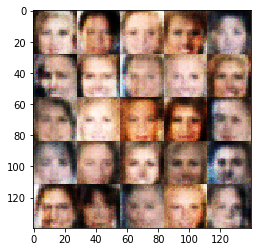

Epoch 1/1... Batch 510... Discriminator Loss: 1.2861... Generator Loss: 0.5817
Epoch 1/1... Batch 520... Discriminator Loss: 1.4773... Generator Loss: 0.3841
Epoch 1/1... Batch 530... Discriminator Loss: 1.1092... Generator Loss: 0.7243
Epoch 1/1... Batch 540... Discriminator Loss: 1.2929... Generator Loss: 1.5123
Epoch 1/1... Batch 550... Discriminator Loss: 1.2734... Generator Loss: 1.2656
Epoch 1/1... Batch 560... Discriminator Loss: 1.1428... Generator Loss: 1.1192
Epoch 1/1... Batch 570... Discriminator Loss: 1.2311... Generator Loss: 1.0441
Epoch 1/1... Batch 580... Discriminator Loss: 1.0957... Generator Loss: 0.7694
Epoch 1/1... Batch 590... Discriminator Loss: 1.2945... Generator Loss: 0.5716
Epoch 1/1... Batch 600... Discriminator Loss: 1.2998... Generator Loss: 0.5397


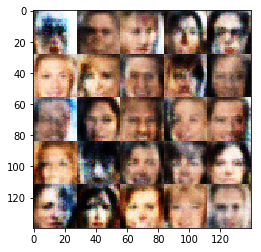

Epoch 1/1... Batch 610... Discriminator Loss: 1.6435... Generator Loss: 0.3154
Epoch 1/1... Batch 620... Discriminator Loss: 1.2741... Generator Loss: 0.5051
Epoch 1/1... Batch 630... Discriminator Loss: 1.6897... Generator Loss: 0.2825
Epoch 1/1... Batch 640... Discriminator Loss: 1.3755... Generator Loss: 0.4416
Epoch 1/1... Batch 650... Discriminator Loss: 1.0715... Generator Loss: 0.7845
Epoch 1/1... Batch 660... Discriminator Loss: 1.2096... Generator Loss: 0.9247
Epoch 1/1... Batch 670... Discriminator Loss: 1.4824... Generator Loss: 0.3947
Epoch 1/1... Batch 680... Discriminator Loss: 1.2217... Generator Loss: 0.4916
Epoch 1/1... Batch 690... Discriminator Loss: 1.7191... Generator Loss: 0.2733
Epoch 1/1... Batch 700... Discriminator Loss: 1.6108... Generator Loss: 0.3109


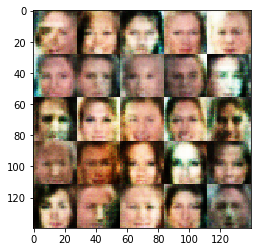

Epoch 1/1... Batch 710... Discriminator Loss: 1.1678... Generator Loss: 0.6099
Epoch 1/1... Batch 720... Discriminator Loss: 1.0638... Generator Loss: 0.8023
Epoch 1/1... Batch 730... Discriminator Loss: 1.2857... Generator Loss: 1.3410
Epoch 1/1... Batch 740... Discriminator Loss: 1.1355... Generator Loss: 1.5925
Epoch 1/1... Batch 750... Discriminator Loss: 1.1143... Generator Loss: 1.1736
Epoch 1/1... Batch 760... Discriminator Loss: 1.0033... Generator Loss: 1.4384
Epoch 1/1... Batch 770... Discriminator Loss: 0.9641... Generator Loss: 0.8315
Epoch 1/1... Batch 780... Discriminator Loss: 1.1548... Generator Loss: 0.8293
Epoch 1/1... Batch 790... Discriminator Loss: 1.4403... Generator Loss: 0.3890
Epoch 1/1... Batch 800... Discriminator Loss: 1.2494... Generator Loss: 0.5974


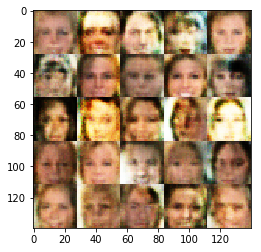

Epoch 1/1... Batch 810... Discriminator Loss: 1.0821... Generator Loss: 0.9799
Epoch 1/1... Batch 820... Discriminator Loss: 1.0443... Generator Loss: 1.2052
Epoch 1/1... Batch 830... Discriminator Loss: 1.0845... Generator Loss: 1.0199
Epoch 1/1... Batch 840... Discriminator Loss: 1.9474... Generator Loss: 0.1878
Epoch 1/1... Batch 850... Discriminator Loss: 1.5050... Generator Loss: 0.3811
Epoch 1/1... Batch 860... Discriminator Loss: 1.1992... Generator Loss: 0.6119
Epoch 1/1... Batch 870... Discriminator Loss: 1.2150... Generator Loss: 0.5353
Epoch 1/1... Batch 880... Discriminator Loss: 1.3540... Generator Loss: 1.0988
Epoch 1/1... Batch 890... Discriminator Loss: 1.5119... Generator Loss: 0.3537
Epoch 1/1... Batch 900... Discriminator Loss: 1.3731... Generator Loss: 0.4577


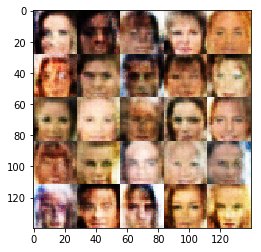

Epoch 1/1... Batch 910... Discriminator Loss: 1.7963... Generator Loss: 0.2364
Epoch 1/1... Batch 920... Discriminator Loss: 0.9712... Generator Loss: 1.1212
Epoch 1/1... Batch 930... Discriminator Loss: 1.2348... Generator Loss: 1.3565
Epoch 1/1... Batch 940... Discriminator Loss: 1.1111... Generator Loss: 0.9603
Epoch 1/1... Batch 950... Discriminator Loss: 1.8499... Generator Loss: 0.2154
Epoch 1/1... Batch 960... Discriminator Loss: 1.6359... Generator Loss: 0.3032
Epoch 1/1... Batch 970... Discriminator Loss: 1.2969... Generator Loss: 0.5020
Epoch 1/1... Batch 980... Discriminator Loss: 1.4239... Generator Loss: 0.4579
Epoch 1/1... Batch 990... Discriminator Loss: 1.5781... Generator Loss: 0.3322
Epoch 1/1... Batch 1000... Discriminator Loss: 1.4356... Generator Loss: 0.3746


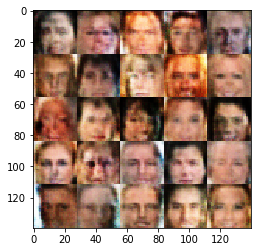

Epoch 1/1... Batch 1010... Discriminator Loss: 1.1538... Generator Loss: 1.2763
Epoch 1/1... Batch 1020... Discriminator Loss: 1.0310... Generator Loss: 1.0385
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2525... Generator Loss: 0.5193
Epoch 1/1... Batch 1040... Discriminator Loss: 0.8611... Generator Loss: 1.2467
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2634... Generator Loss: 1.4752
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0177... Generator Loss: 0.9124
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4363... Generator Loss: 1.1537
Epoch 1/1... Batch 1080... Discriminator Loss: 1.8709... Generator Loss: 0.2158
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3115... Generator Loss: 1.2543
Epoch 1/1... Batch 1100... Discriminator Loss: 1.0758... Generator Loss: 0.9881


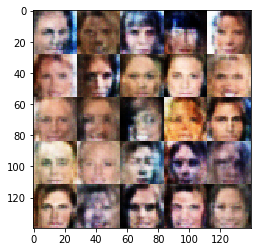

Epoch 1/1... Batch 1110... Discriminator Loss: 1.1888... Generator Loss: 1.3266
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0222... Generator Loss: 0.9591
Epoch 1/1... Batch 1130... Discriminator Loss: 1.6732... Generator Loss: 0.2832
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3965... Generator Loss: 0.4013
Epoch 1/1... Batch 1150... Discriminator Loss: 1.0393... Generator Loss: 0.7759
Epoch 1/1... Batch 1160... Discriminator Loss: 1.6192... Generator Loss: 0.3129
Epoch 1/1... Batch 1170... Discriminator Loss: 1.5377... Generator Loss: 0.3479
Epoch 1/1... Batch 1180... Discriminator Loss: 1.1554... Generator Loss: 0.6321
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1207... Generator Loss: 1.1388
Epoch 1/1... Batch 1200... Discriminator Loss: 1.0541... Generator Loss: 0.8226


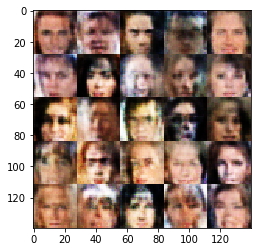

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1836... Generator Loss: 0.6560
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3819... Generator Loss: 0.4507
Epoch 1/1... Batch 1230... Discriminator Loss: 1.1407... Generator Loss: 1.1293
Epoch 1/1... Batch 1240... Discriminator Loss: 1.3233... Generator Loss: 0.4831
Epoch 1/1... Batch 1250... Discriminator Loss: 1.0612... Generator Loss: 1.2734
Epoch 1/1... Batch 1260... Discriminator Loss: 1.0760... Generator Loss: 0.8509
Epoch 1/1... Batch 1270... Discriminator Loss: 1.3193... Generator Loss: 0.5232
Epoch 1/1... Batch 1280... Discriminator Loss: 1.4418... Generator Loss: 0.3828
Epoch 1/1... Batch 1290... Discriminator Loss: 1.5678... Generator Loss: 1.9554
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9877... Generator Loss: 0.9241


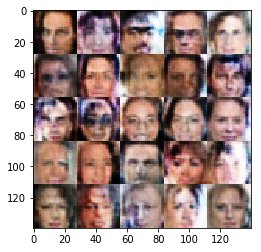

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2285... Generator Loss: 0.5090
Epoch 1/1... Batch 1320... Discriminator Loss: 1.3705... Generator Loss: 0.5587
Epoch 1/1... Batch 1330... Discriminator Loss: 1.2636... Generator Loss: 0.5596
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2274... Generator Loss: 0.5201
Epoch 1/1... Batch 1350... Discriminator Loss: 1.1089... Generator Loss: 1.2540
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2093... Generator Loss: 1.1946
Epoch 1/1... Batch 1370... Discriminator Loss: 1.1443... Generator Loss: 1.0703
Epoch 1/1... Batch 1380... Discriminator Loss: 1.0231... Generator Loss: 1.0137
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1112... Generator Loss: 1.3420
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3179... Generator Loss: 0.4576


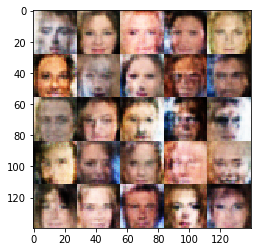

Epoch 1/1... Batch 1410... Discriminator Loss: 1.0523... Generator Loss: 0.6837
Epoch 1/1... Batch 1420... Discriminator Loss: 1.2062... Generator Loss: 1.0287
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1293... Generator Loss: 1.4382
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3003... Generator Loss: 0.7210
Epoch 1/1... Batch 1450... Discriminator Loss: 1.5536... Generator Loss: 1.2286
Epoch 1/1... Batch 1460... Discriminator Loss: 1.1909... Generator Loss: 1.0428
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0511... Generator Loss: 0.8570
Epoch 1/1... Batch 1480... Discriminator Loss: 1.5575... Generator Loss: 0.3225
Epoch 1/1... Batch 1490... Discriminator Loss: 1.0881... Generator Loss: 0.8968
Epoch 1/1... Batch 1500... Discriminator Loss: 1.1912... Generator Loss: 0.5214


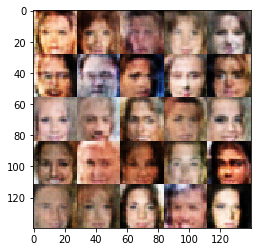

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1678... Generator Loss: 0.6467
Epoch 1/1... Batch 1520... Discriminator Loss: 0.9923... Generator Loss: 1.4734
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0455... Generator Loss: 0.8037
Epoch 1/1... Batch 1540... Discriminator Loss: 1.6669... Generator Loss: 0.2768
Epoch 1/1... Batch 1550... Discriminator Loss: 1.2971... Generator Loss: 0.4835
Epoch 1/1... Batch 1560... Discriminator Loss: 1.2875... Generator Loss: 1.0195
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2043... Generator Loss: 1.0267
Epoch 1/1... Batch 1580... Discriminator Loss: 1.5917... Generator Loss: 0.3152


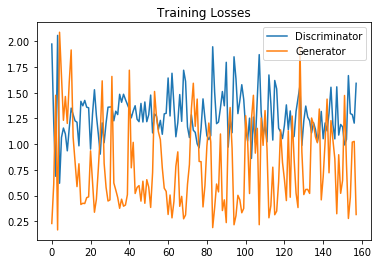

In [21]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.